In [1]:
import pypolychord as pp
from pypolychord.settings import PolyChordSettings as Settings
from mpi4py import MPI
from anesthetic import NestedSamples
import matplotlib.pyplot as plt
import numpy as np

def generate_model(bounds, means, covs):
    thetamin, thetamax = bounds[:,0], bounds[:,1]
    invCov = np.linalg.inv(covs)

    def prior(cube):
        return thetamin + cube * (thetamax - thetamin)

    def log_likelihood(theta):
        return (-(theta - means) @ invCov @ (theta - means) / 2.0 , [])

    return prior, log_likelihood


def higson(samples):
    for x in samples: 
        logX = np.log(samples[x].nlive / (samples[x].nlive + 1)).cumsum()
        LXi = samples[x].logL / samples[x].beta + logX
        LX = np.exp(LXi - LXi.max())
        plt.xlabel(r'$- \log X$')
        plt.ylabel('LX')
        plt.plot(-logX, LX, label=x)
    plt.legend()

bounds = np.array([[-1e6, 1e6], [-1e5, 1e5], [-1e3, 1e3]])
means = np.array([1, 2, 3])
covs = np.array([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])
output = {} 
samples = {}

In [2]:
control = generate_model(bounds, means, covs)
settings = Settings(len(means), 0, file_root="unperturbed")
output["unperturbed"] = pp.run_polychord(control[1], len(means), 0, settings, prior=control[0])

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :      75
nDims    :       3
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/unperturbed.resume

Resuming from previous run
number of repeats:           15
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2825                              |
| log(Z) =          -30.25588 +/-            0.65679 |
|____________________________________________________|


In [3]:
samples["unperturbed"] = NestedSamples(root='chains/unperturbed')

(<Figure size 432x288 with 12 Axes>,
                                                 0  \
 0  DiagonalAxes(0.125,0.628333;0.258333x0.251667)   
 1   AxesSubplot(0.125,0.376667;0.258333x0.251667)   
 2      AxesSubplot(0.125,0.125;0.258333x0.251667)   
 
                                                    1  \
 0   AxesSubplot(0.383333,0.628333;0.258333x0.251667)   
 1  DiagonalAxes(0.383333,0.376667;0.258333x0.251667)   
 2      AxesSubplot(0.383333,0.125;0.258333x0.251667)   
 
                                                   2  
 0  AxesSubplot(0.641667,0.628333;0.258333x0.251667)  
 1  AxesSubplot(0.641667,0.376667;0.258333x0.251667)  
 2    DiagonalAxes(0.641667,0.125;0.258333x0.251667)  )

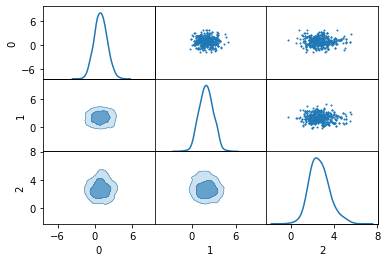

In [4]:
samples["unperturbed"].plot_2d([0, 1, 2])

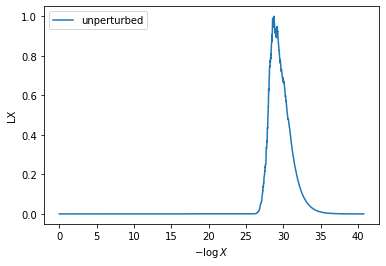

In [5]:
higson({"unperturbed": samples["unperturbed"]})

In [6]:
import supernest as sn

proposal = sn.gaussian_proposal(bounds.T, means, covs, loglike=control[1])
proposal = sn.superimpose([proposal, control], nDims=len(means))
settings = Settings(proposal.nDims, 0, file_root="proposal_unperturbed")
output["proposal_unperturbed"] = pp.run_polychord(proposal.likelihood, proposal.nDims, 0, settings, proposal.prior)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_unperturbed.resume

Resuming from previous run
number of repeats:           25
started sampling

_________________
lives      | 125 |
phantoms   |2315 |
posteriors |  24 |
equals     |  21 |
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
ncluster   =       1 /       1
ndead      =                 126
nposterior =                  24
nequals    =                  18
nlike      =               12575
<nlike>    =          10.04   (           0.40 per slice )
log(Z)     =          -34.14 +/-  0.20
log(Z_1)   =          -34.14 +/-  0.20 (still evaluati

In [7]:
!rm -rf "chains/proposal_unperturbed_phys_live-birth.txt"

/home/app/.local/lib/python3.9/site-packages/anesthetic/samples.py:748: RuntimeWarning: 125 out of 352 samples have logL <= logL_birth,
125 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"


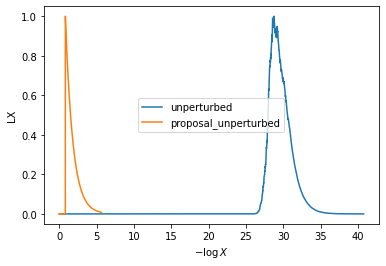

In [8]:
samples["proposal_unperturbed"] = NestedSamples(root="chains/proposal_unperturbed")
higson(samples)

## Perturbing the scale of the covariance matrix

In [9]:
def perturb_scale(scale=1):
    key = f"proposal_scaled_{scale}"
    proposal = sn.gaussian_proposal(bounds.T, means, scale*covs, loglike=control[1])
    proposal = sn.superimpose([proposal, control], nDims=len(means))
    settings = Settings(proposal.nDims, 0, file_root=key)
    output[key] = pp.run_polychord(proposal.likelihood, proposal.nDims, 0, settings, proposal.prior)
    samples[key] = NestedSamples(root=f"chains/{key}")

In [55]:
perturb_scale(5)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_scaled_5.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1366                              |
| log(Z) =          -32.12908 +/-            0.12517 |
|____________________________________________________|


In [56]:
#perturb_scale(3)

In [57]:
perturb_scale(2)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_scaled_2.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1200                              |
| log(Z) =          -32.18375 +/-            0.08882 |
|____________________________________________________|


In [58]:
# perturb_scale(1.5)

In [59]:
perturb_scale(0.75)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_scaled_0.75.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1462                              |
| log(Z) =          -32.26915 +/-            0.07907 |
|____________________________________________________|


In [60]:
# perturb_scale(0.5)

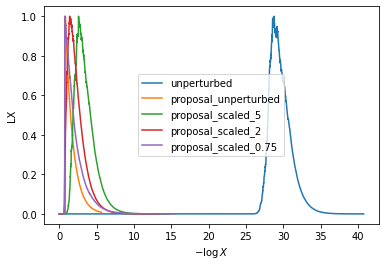

In [61]:
higson(samples)
plt.savefig("figures/higson-scale.pdf")

## Perturbing the location

In [54]:
samples = {
    "unperturbed": samples["unperturbed"],
    "proposal_unperturbed": samples["proposal_unperturbed"]
}

In [19]:
def perturb_loc(loc=1):
    key = f"proposal_loc_{loc}"
    delta = np.array([loc, 0, 0]) # shift along the 0-direction by `loc` units.
    proposal = sn.gaussian_proposal(bounds.T, means - loc, covs, loglike=control[1])
    proposal = sn.superimpose([proposal, control], nDims=len(means))
    settings = Settings(proposal.nDims, 0, file_root=key)
    output[key] = pp.run_polychord(proposal.likelihood, proposal.nDims, 0, settings, proposal.prior)
    samples[key] = NestedSamples(root=f"chains/{key}")

In [20]:
perturb_loc(1)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_1.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1986                              |
| log(Z) =          -32.17344 +/-            0.13179 |
|____________________________________________________|


In [21]:
perturb_loc(2)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_2.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         3543                              |
| log(Z) =          -32.53572 +/-            0.22025 |
|____________________________________________________|


In [22]:
perturb_loc(5) # FUCKING STOP ALREADY!!

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_5.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =        11754                              |
| log(Z) =          -27.23002 +/-            1.33094 |
|____________________________________________________|


/home/app/.local/lib/python3.9/site-packages/anesthetic/samples.py:748: RuntimeWarning: 1 out of 11754 samples have logL <= logL_birth,
1 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"


In [23]:
perturb_loc(0.25)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_0.25.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1285                              |
| log(Z) =          -32.32671 +/-            0.08394 |
|____________________________________________________|


In [24]:
perturb_loc(3)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_3.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         6484                              |
| log(Z) =          -32.70390 +/-            0.34542 |
|____________________________________________________|


In [25]:
perturb_loc(4)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_4.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         9912                              |
| log(Z) =          -29.42403 +/-            0.77943 |
|____________________________________________________|


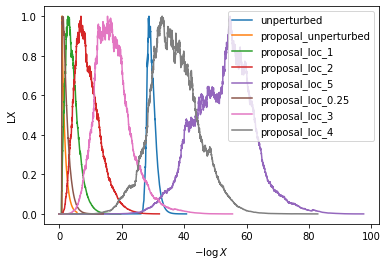

In [27]:
higson(samples)
plt.savefig("figures/higson-loc.pdf")

Here we can make use of either histeretic priors, or a simpler solution of 

## Simultaneous scale and location perturbations

In [28]:
samples = {
    "unperturbed": samples["unperturbed"],
    "proposal_unperturbed": samples["proposal_unperturbed"]
}

In [29]:
def perturb_loc_and_scale(loc=1):
    key = f"proposal_loc_{loc}_scale_{loc}"
    delta = np.array([loc, 0, 0]) # shift along the 0-direction by `loc` units.
    proposal = sn.gaussian_proposal(bounds.T, means - loc, loc*loc*covs, loglike=control[1])
    proposal = sn.superimpose([proposal, control], nDims=len(means))
    settings = Settings(proposal.nDims, 0, file_root=key)
    output[key] = pp.run_polychord(proposal.likelihood, proposal.nDims, 0, settings, proposal.prior)
    samples[key] = NestedSamples(root=f"chains/{key}")

In [30]:
perturb_loc_and_scale(1)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_1_scale_1.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2014                              |
| log(Z) =          -32.31843 +/-            0.13307 |
|____________________________________________________|


In [31]:
perturb_loc_and_scale(2)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_2_scale_2.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1604                              |
| log(Z) =          -32.38014 +/-            0.16384 |
|____________________________________________________|


In [32]:
perturb_loc_and_scale(5)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_5_scale_5.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         1854                              |
| log(Z) =          -32.05937 +/-            0.20930 |
|____________________________________________________|


In [33]:
perturb_loc_and_scale(10)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_10_scale_10.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2125                              |
| log(Z) =          -32.20075 +/-            0.24839 |
|____________________________________________________|


In [34]:
perturb_loc_and_scale(20)

PolyChord: MPI is already initilised, not initialising, and will not finalize

PolyChord: Next Generation Nested Sampling
copyright: Will Handley, Mike Hobson & Anthony Lasenby
  version: 1.18.2
  release: 7th April 2020
    email: wh260@mrao.cam.ac.uk

Run Settings
nlive    :     125
nDims    :       5
nDerived :       0
Doing Clustering
Generating equally weighted posteriors
Generating weighted posteriors
Clustering on posteriors
Writing a resume file tochains/proposal_loc_20_scale_20.resume

Resuming from previous run
number of repeats:           25
started sampling

 ____________________________________________________ 
|                                                    |
| ndead  =         2385                              |
| log(Z) =          -32.22024 +/-            0.27809 |
|____________________________________________________|


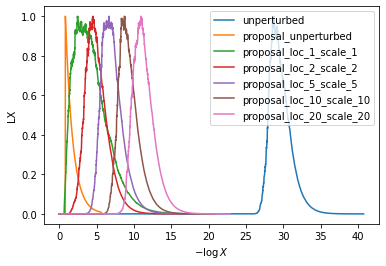

In [36]:
higson(samples)
plt.savefig("figures/higson-scale-and-loc.pdf")

As long as we're honest about how well we know the location of the posterior peaks, we get a speedup. However if our guess has less than $10 \sigma$ confidence, we're better off using a uniform prior. 

**NOTE**: The turnover point is highly dependent on the width of the original prior: the probability that the likelihood is dominated by the proposal is $O(\exp ( - 1)$, while the probability of sampling over the same region is $O(\sigma / V_{box})$, which in our case is a tiny quantity. Because of the way nested sampling works, the proposal is preferred (despite not having any useful information) and at this stage it is nearly impossible to sample over this proposal. 

As an alternative, a superposition with PPR might be able to cope with this issue better. It skews more towards reliability, and without superposition is not as effective in cases where the distance is small. It should be considered as one of the proposal types if the hypothesis is a complete shot in the dark. 

In [37]:
def prettify(s):
    s = s.replace("_", " ")
    s = s.capitalize()
    s = s.replace("Unperturbed", "Control")
    s = s.replace("Proposal ", "")
    s = s.replace("loc ", "$ \Delta \mu= $")
    s = s.replace("scaled ", "$\\sigma\\times$")
    s = s.replace("scale ", "$\\sigma\\times$")
    return s

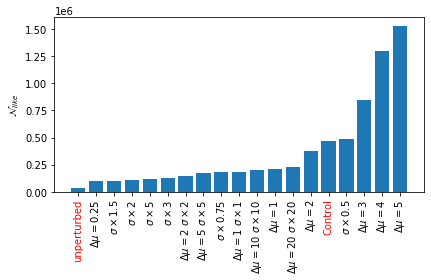

In [64]:
nlikes = [(x, output[x].nlike) for x in output]
nlikes.sort(key = lambda y: y[1])
labels = [prettify(y[0]) for y in nlikes]
nlikes = [y[1] for y in nlikes]
plt.xticks(range(len(output)), labels, rotation=90);
plt.ylabel(r"$\mathcal{N}_{like}$");
plt.bar(range(len(output)), nlikes);

ld = {n.get_text(): n for n in plt.gca().get_xticklabels() }
ld["unperturbed"].set_c("red")
ld["Control"].set_c("red")

plt.savefig("figures/ranking-nlike.pdf", bbox_inches = "tight")

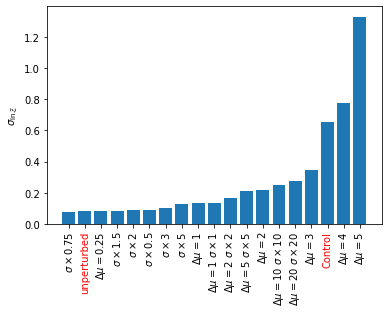

In [65]:
Zs = [(x, output[x].logZerr) for x in output]
Zs.sort(key = lambda y: y[1])
labels = [prettify(y[0]) for y in Zs]
Zs = [y[1] for y in Zs]
plt.bar(range(len(output)), Zs)
plt.xticks(range(len(output)), labels, rotation=90);
plt.ylabel(r"$\sigma_{\ln \mathcal{Z}}$");
ld = {n.get_text(): n for n in plt.gca().get_xticklabels() }
ld["unperturbed"].set_c("red")
ld["Control"].set_c("red")
plt.savefig("figures/ranking-error.pdf", bbox_inches = "tight")

/home/app/.local/lib/python3.9/site-packages/anesthetic/samples.py:748: RuntimeWarning: 125 out of 352 samples have logL <= logL_birth,
125 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"
/home/app/.local/lib/python3.9/site-packages/anesthetic/samples.py:748: RuntimeWarning: 1 out of 11754 samples have logL <= logL_birth,
1 of which have logL == logL_birth.
This may just indicate numerical rounding errors at the peak of the likelihood, but further investigation of the chains files is recommended.
Dropping the invalid samples.
  warnings.warn("%i out of %i samples have logL <= logL_birth,"


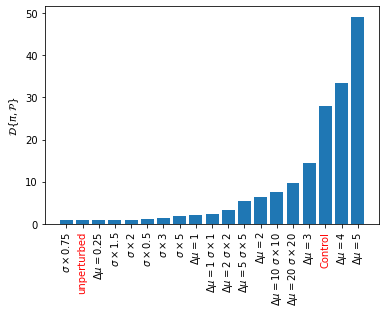

In [66]:
all_samples = {x: NestedSamples(root=f"chains/{x}") for x in output}
Ds = [(x, all_samples[x].D()) for x in output]
Ds.sort(key = lambda y: y[1])
labels = [prettify(y[0]) for y in Ds]
Ds = [y[1] for y in Ds]
plt.bar(range(len(output)), Ds)
plt.xticks(range(len(output)), labels, rotation=90);
plt.ylabel(r"$\mathcal{D}\{\pi, \mathcal{P} \}$");
ld = {n.get_text(): n for n in plt.gca().get_xticklabels() }
ld["unperturbed"].set_c("red")
ld["Control"].set_c("red")
plt.savefig("figures/ranking-dkl.pdf", bbox_inches = "tight")